# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

# MADDPG 

## Importing Modules and Setting Environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from  collections  import deque
from itertools import count
import torch
import time

import numpy as np
import random
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
%matplotlib inline

from maddpg import maddpg

# Defining Environment 

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

# Setting up Agent and Function

In [6]:
# Defining maddpg Agent
maddpg = maddpg(state_size=state_size, action_size=action_size, random_seed=8)

In [7]:
def maddpg_agent(n_episodes=5000, max_len=100):
    # create empty score list
    scores = []
    # initialize deque
    scores_deque = deque(maxlen=max_len)
    
    # additional Play-counter for Trjaectory's
    t=1
    
    # Iterate over episodes 
    for ep in range(1,n_episodes+1):     
        # Claculation Timer
        if ep==1: 
            time_start=time.time()
            
        env_info = env.reset(train_mode=True)[brain_name] 
        states = env_info.vector_observations
        maddpg.reset()
        score = np.zeros(num_agents)
        
        # Iterate over timesteps
        while True:
            actions = maddpg.act(states)
            # send all actions to the environment
            env_info = env.step(actions)[brain_name]
            # get next state (for each agent)
            next_states = env_info.vector_observations
            # get reward (for each agent)
            rewards = env_info.rewards
            # see if episode finished
            dones = env_info.local_done
            
            
            # Add Trajectory's
            #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            maddpg.step(states, actions, rewards, next_states, dones, t)
            
            t+=1
            
            # Defining next States and rewards     
            states = next_states
            score += rewards
            if np.any(dones):
                break 
                       
      
    
    
        # Append Scores
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))  
        
        # Printing Results each episode
        print('\rEpisode: {}  Mean_Score for all Agents: {:.4f}  Mean_Score_over_deque: {:.4f}'.format(ep, np.mean(score), np.mean(scores_deque)))
        
        
        # Print Calculation Time each 5 Episode
        if ep % 5==0:
            time_end=round((time.time()-time_start)/60) 
            print('Time of Calucation: {} Minutes'.format(time_end))
            
        # Defining rubric-conditions: mean_score (over deque) over 0.5 in minimum of 100 episodes
        
        if np.mean(scores_deque) > 0.5 and ep>100:
            print('\nEnvironment solved in {} episodes with a mean score of {} - Finally :-) !'.format(ep, np.mean(scores_deque)))
            
            # Savig weights for both agents 
            for i in range(num_agents):
                torch.save(maddpg.maddpg_agent[i].actor_local.state_dict(), 'actor1_checkpoint.pth')
                torch.save(maddpg.maddpg_agent[i].actor_local.state_dict(), 'actor2_checkpoint.pth')
            break
            
    return scores, scores_deque

In [8]:
scores,scores_deque = maddpg_agent()

Episode: 1  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 2  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 3  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 4  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 5  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Time of Calucation: 0 Minutes
Episode: 6  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 7  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 8  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 9  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 10  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Time of Calucation: 0 Minutes
Episode: 11  Mean_Score for all Agents: -0.0050  Mean_Score_over_deque: -0.0050
Episode: 12  Mean_Score for all Agents: -0.0050  Mean_Score_over_dequ

# Saving and Plotting

In [21]:
# Save both scoe-results 
score_df=pd.DataFrame(scores,columns=['Mean Scores'])
dscore_df=pd.DataFrame(list(scores_deque),columns=['Mean Scores'])
score_df.to_csv('score.csv',sep=';')
dscore_df.to_csv('dscore.csv',sep=';')

In [16]:
# Saving Results
df_score=pd.read_csv('score.csv',sep=';').rename(columns={'Unnamed: 0':'Episode'})
df_dscore=pd.read_csv('dscore.csv',sep=';').rename(columns={'Unnamed: 0':'Episode'})

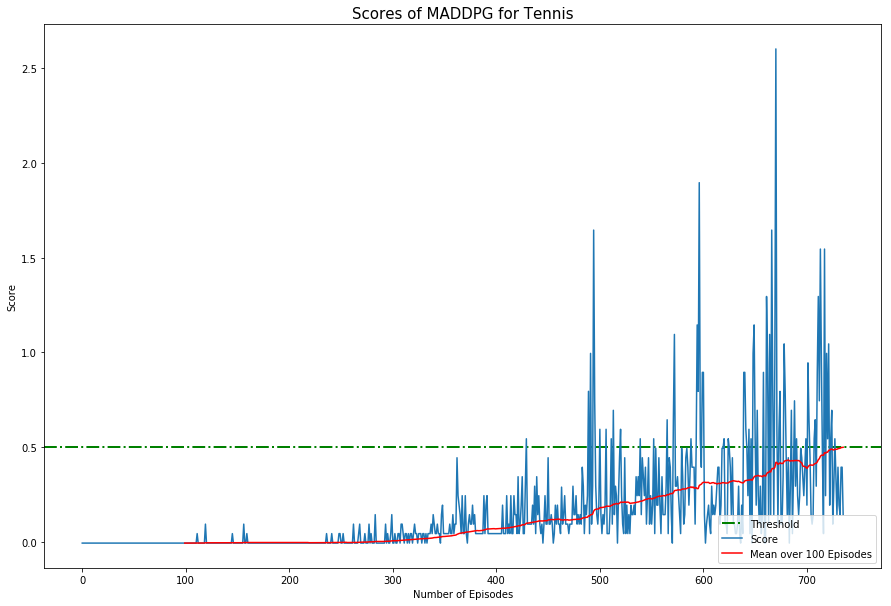

In [46]:
# Plotting Results 

plt.figure(figsize=(15,10))
plt.title('Scores of MADDPG for Tennis',size=15)
plt.axhline(y=.5, xmin=0.0, color='g', linestyle='dashdot', linewidth=2.0, label='Threshold')
plt.plot(df_score['Mean Scores'], label='Score')
plt.plot(df_score['Mean Scores'].rolling(window=100).mean(),label='Mean over 100 Episodes',color='red')
plt.ylabel('Score')
plt.xlabel('Number of Episodes')
plt.legend(loc='lower right', fontsize=10)

In [ ]:
env.close()